# Energy Load Forecasting with Prophet

Context:<br />
A company creates an app that helps minimize energy costs for users,
figuring out when to use batteries and when to use the grid.<br />
To do this, they need to forecast the energy load for the next 2 days.

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.dates import HourLocator, DateFormatter

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from neuralprophet import NeuralProphet
# xgboost
from xgboost import XGBRegressor
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import os
import json
from multiprocessing import Pool, cpu_count

In [2]:
# Verify cuda is available
import torch

print(torch.__version__)
print(torch.cuda.is_available())      # Should be True
# print(torch.cuda.get_device_name(0))  # Should show your GPU name

2.5.1+cu121
True


In [3]:
RANDOM_STATE = 42

## Visualization Setup

In [4]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [5]:
sns.color_palette('muted')

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [6]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [7]:
blue = sns.color_palette('colorblind')[0]
green = sns.color_palette('colorblind')[2]

In [8]:
font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

sns.set_theme(
    style='darkgrid',
    context='notebook',
    font=font_prop.get_name(),
    rc={
        'font.weight': 'semibold',
        'axes.labelweight': 'semibold',
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.labelsize': 'medium',
        }
    )

## Load Data

In [9]:
# Source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
pjmw_df = pd.read_csv('data/PJMW_hourly.csv')

In [10]:
pjmw_df.shape

(143206, 2)

In [11]:
pjmw_df.isna().sum()

Datetime    0
PJMW_MW     0
dtype: int64

In [12]:
pjmw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [13]:
pjmw_df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [14]:
pjmw_df.rename(columns={'Datetime': 'datetime', 'PJMW_MW': 'mw'}, inplace=True)

In [15]:
pjmw_df['datetime'] = pd.to_datetime(pjmw_df['datetime'])

In [16]:
pjmw_df

,datetime,mw
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [17]:
pjmw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  143206 non-null  datetime64[ns]
 1   mw        143206 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


Are there any duplicates in the datetime column?

In [18]:
pjmw_df['datetime'].duplicated().sum()

4

In [19]:
pjmw_df[pjmw_df['datetime'].duplicated(keep=False)]

,datetime,mw
104424,2014-11-02 02:00:00,4613.0
104425,2014-11-02 02:00:00,4571.0
113208,2015-11-01 02:00:00,3927.0
113209,2015-11-01 02:00:00,3832.0
121848,2016-11-06 02:00:00,4114.0
121849,2016-11-06 02:00:00,4089.0
130656,2017-11-05 02:00:00,4042.0
130657,2017-11-05 02:00:00,3984.0


These duplicate entries are really close to each other in terms of
consumptions, they can be dropped.

In [20]:
pjmw_df = pjmw_df.drop_duplicates(subset='datetime', keep='last').reset_index(drop=True)

Are there any missing dates in the datetime column?

In [21]:
pjmw_df.sort_values('datetime', inplace=True)
full_range = pd.date_range(start=pjmw_df['datetime'].min(), end=pjmw_df['datetime'].max(), freq='H')

In [22]:
missing_dates_df = pd.DataFrame({'datetime': full_range.difference(pjmw_df['datetime'])})
missing_dates_df

,datetime
0,2002-04-07 03:00:00
1,2002-10-27 02:00:00
2,2003-04-06 03:00:00
3,2003-10-26 02:00:00
4,2004-04-04 03:00:00
5,2004-10-31 02:00:00
6,2005-04-03 03:00:00
7,2005-10-30 02:00:00
8,2006-04-02 03:00:00
9,2006-10-29 02:00:00


That's peculiar. Could this be a timezone issue perhaps? Let's see which timezone the datetime column is in.

I couldn't find the timezone information in the dataset, so let's interpolate these
missing dates and proceed with the analysis.

In [23]:
pjmw_df = pjmw_df.set_index('datetime').reindex(full_range).rename_axis('datetime').reset_index()
pjmw_df['mw'] = pjmw_df['mw'].interpolate(method='linear')

In [24]:
pjmw_df['year'] = pjmw_df['datetime'].dt.year
pjmw_df['month'] = pjmw_df['datetime'].dt.month
pjmw_df['day'] = pjmw_df['datetime'].dt.day
pjmw_df['hour'] = pjmw_df['datetime'].dt.hour
pjmw_df['day_of_week'] = pjmw_df['datetime'].dt.dayofweek
pjmw_df['day_of_year'] = pjmw_df['datetime'].dt.dayofyear
pjmw_df['week_of_year'] = pjmw_df['datetime'].dt.isocalendar().week
pjmw_df['quarter'] = pjmw_df['datetime'].dt.quarter

## EDA

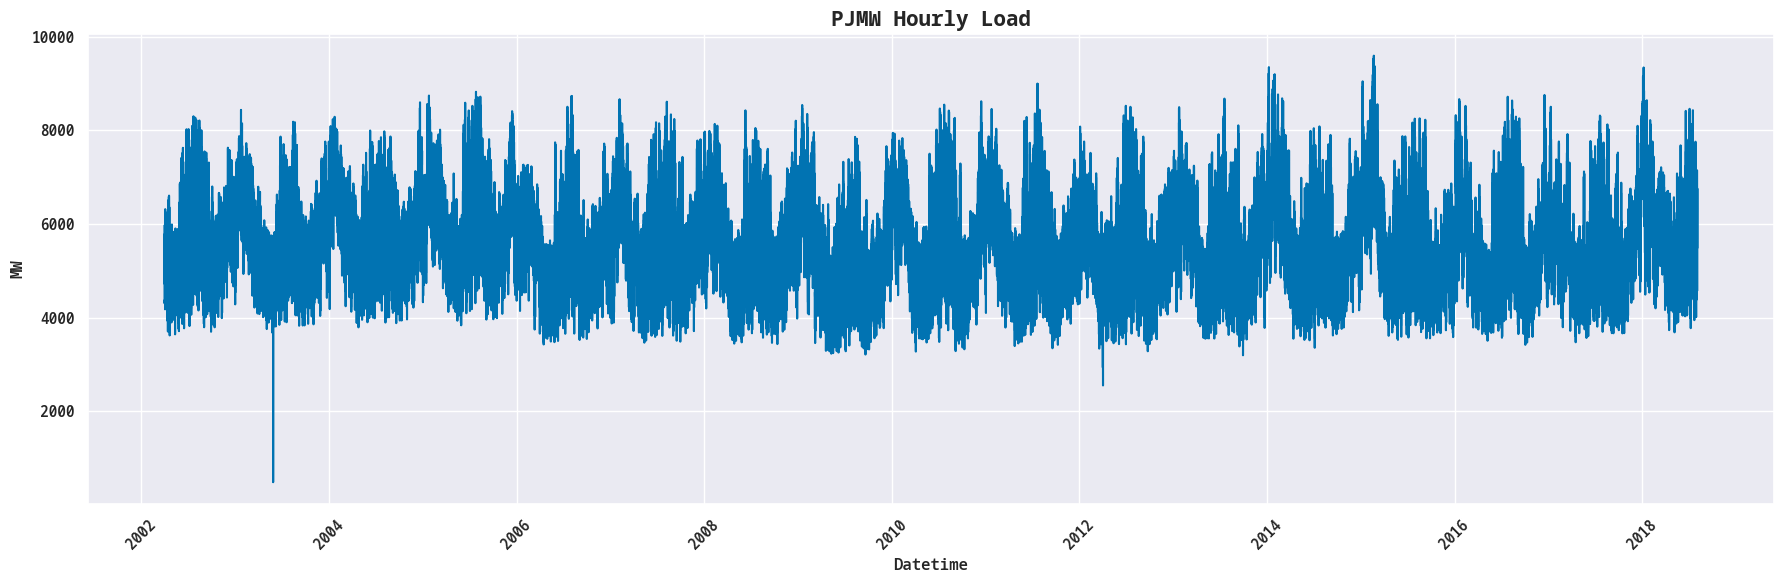

In [25]:
fig, ax = plt.subplots(figsize=(18, 6))

sns.lineplot(
        data=pjmw_df,
        x='datetime',
        y='mw',
        ax=ax,
        color=blue,
        linewidth=1.5
        )

ax.set_title('PJMW Hourly Load')
ax.set_xlabel('Datetime')
ax.set_ylabel('MW')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
pjmw_df.head()

,datetime,mw,year,month,day,hour,day_of_week,day_of_year,week_of_year,quarter
0,2002-04-01 01:00:00,4374.0,2002,4,1,1,0,91,14,2
1,2002-04-01 02:00:00,4306.0,2002,4,1,2,0,91,14,2
2,2002-04-01 03:00:00,4322.0,2002,4,1,3,0,91,14,2
3,2002-04-01 04:00:00,4359.0,2002,4,1,4,0,91,14,2
4,2002-04-01 05:00:00,4436.0,2002,4,1,5,0,91,14,2


Let's see how each of the time features correlates with the load (MW).

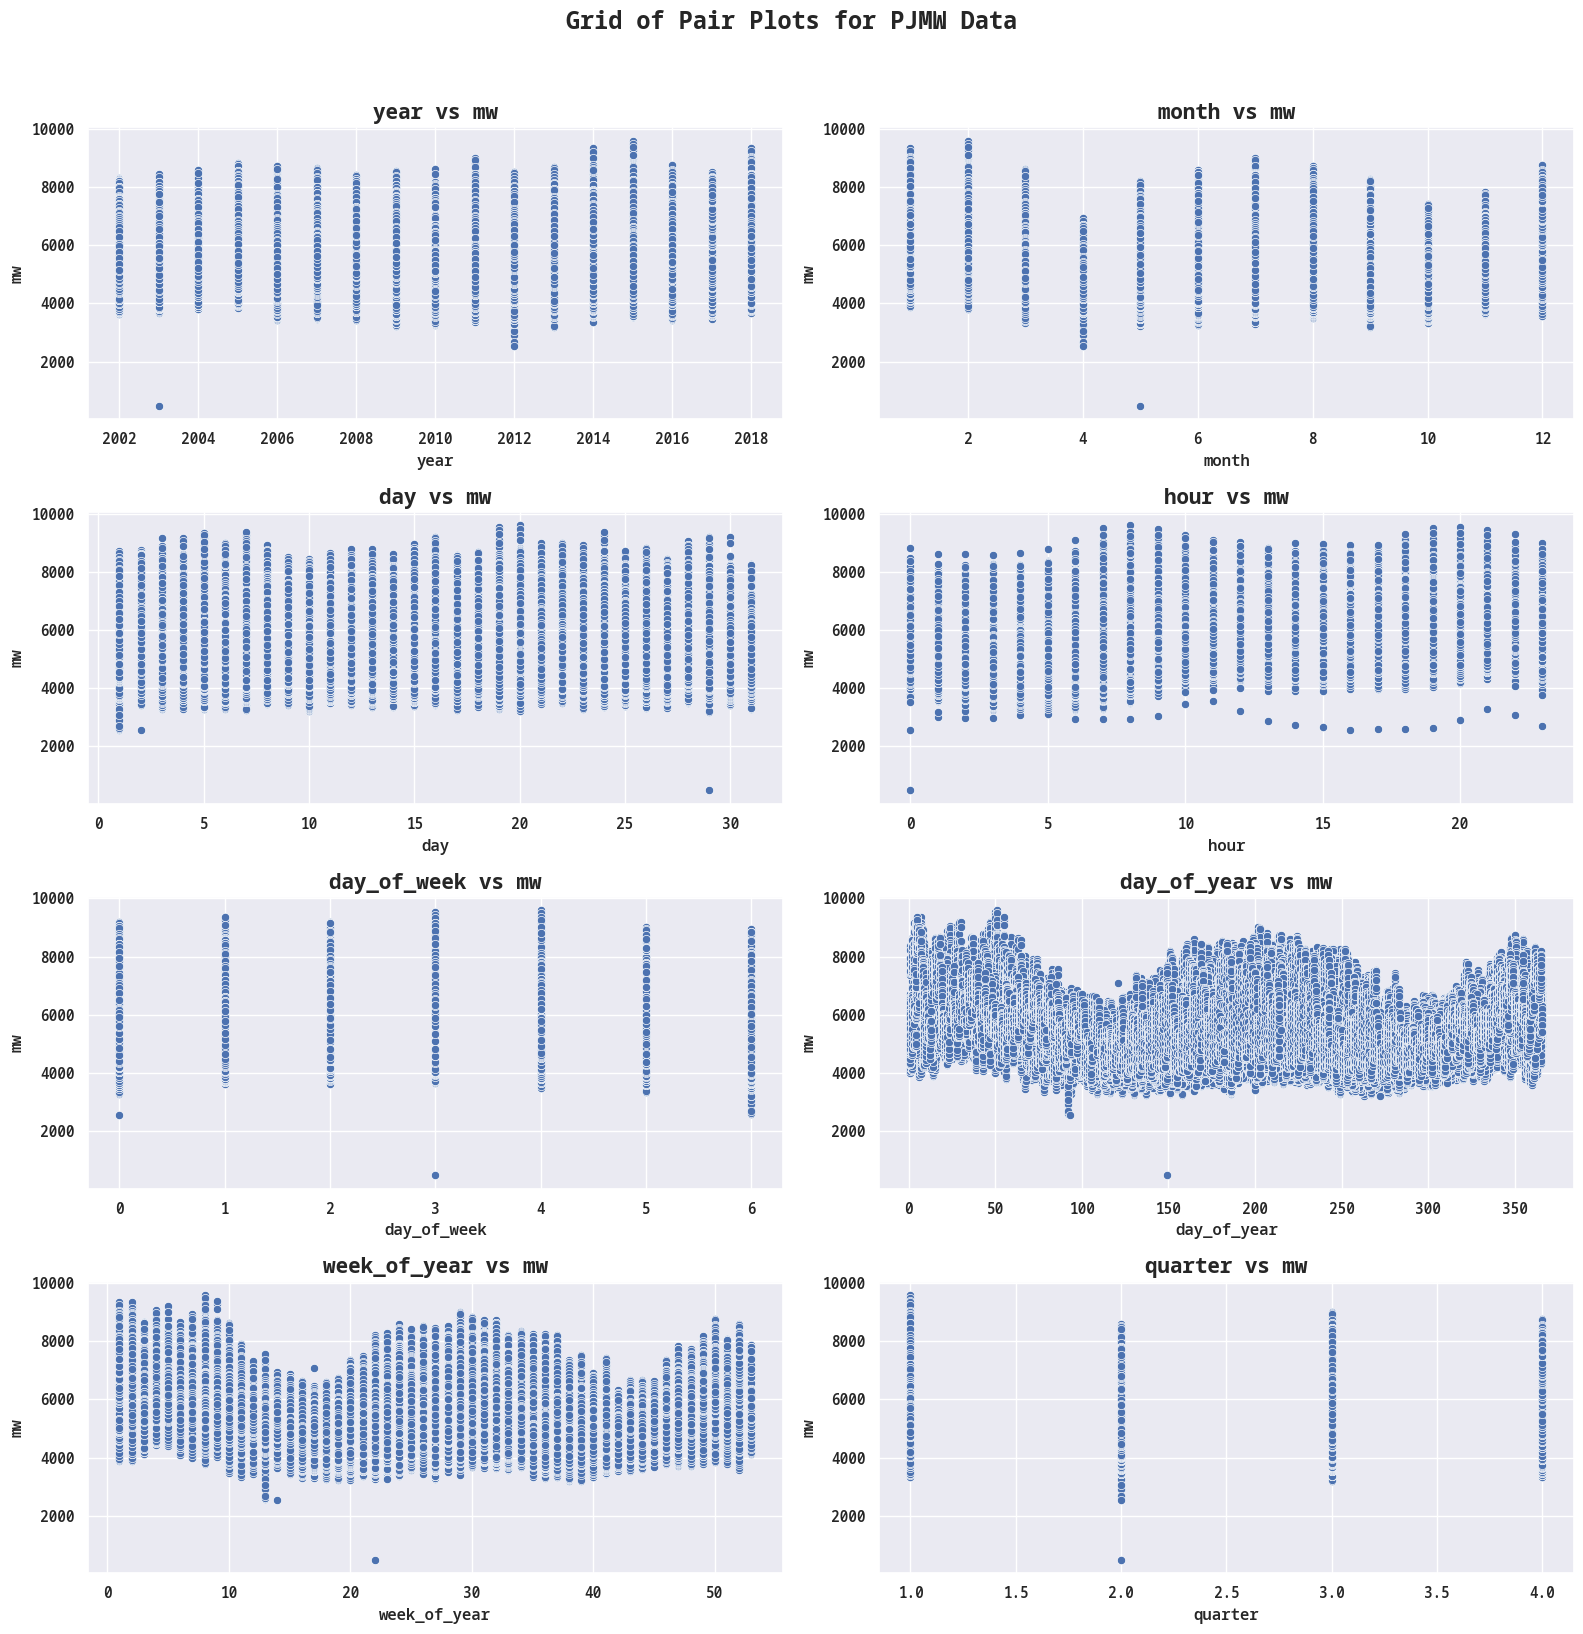

In [27]:
x_vars = [
    'year',
    'month',
    'day',
    'hour',
    'day_of_week',
    'day_of_year',
    'week_of_year',
    'quarter'
]

fig, axes = plt.subplots(4, 2, figsize=(16, 16))  # 4 rows, 2 columns
axes = axes.flatten()

for i, var in enumerate(x_vars):
    sns.scatterplot(data=pjmw_df, x=var, y='mw', ax=axes[i])
    axes[i].set_title(f'{var} vs mw')

plt.suptitle('Grid of Pair Plots for PJMW Data', fontsize=18, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

In [28]:
train_val_test_df = pjmw_df.copy()[['datetime', 'mw']]. \
        rename(columns={'datetime': 'ds', 'mw': 'y'}). \
        sort_values(by='ds'). \
        reset_index(drop=True)

train_val_test_df.head()

,ds,y
0,2002-04-01 01:00:00,4374.0
1,2002-04-01 02:00:00,4306.0
2,2002-04-01 03:00:00,4322.0
3,2002-04-01 04:00:00,4359.0
4,2002-04-01 05:00:00,4436.0


In [29]:
train_val_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143232 entries, 0 to 143231
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      143232 non-null  datetime64[ns]
 1   y       143232 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


Some sanity checks

In [30]:
train_val_test_df['ds'].min(), train_val_test_df['ds'].max()

(Timestamp('2002-04-01 01:00:00'), Timestamp('2018-08-03 00:00:00'))

In [31]:
train_val_test_df.isna().sum()

ds    0
y     0
dtype: int64

In [32]:
train_val_test_df['ds'].duplicated().sum()

0

In [33]:
cuttoff_date = train_val_test_df['ds'].max() - pd.Timedelta(days=365 * 3)  # 3 years ago
train_val_test_df = train_val_test_df[train_val_test_df['ds'] >= cuttoff_date].reset_index(drop=True)

In [34]:
train_val_test_df['day_of_week'] = train_val_test_df['ds'].dt.day_name()
train_val_test_df['day_of_week'].value_counts().sort_index()

day_of_week
Friday       3745
Monday       3744
Saturday     3744
Sunday       3744
Thursday     3768
Tuesday      3768
Wednesday    3768
Name: count, dtype: int64

In [35]:
total_days = (train_val_test_df['ds'].max() - train_val_test_df['ds'].min()).days

train_days = int(0.7 * total_days)
val_days   = int(0.15 * total_days)
test_days  = total_days - train_days - val_days

train_end = train_val_test_df['ds'].min() + pd.Timedelta(days=train_days)
val_end   = train_end + pd.Timedelta(days=val_days)

train_df = train_val_test_df[train_val_test_df['ds'] <= train_end]
val_df   = train_val_test_df[(train_val_test_df['ds'] > train_end) & (train_val_test_df['ds'] <= val_end)]
test_df  = train_val_test_df[train_val_test_df['ds'] > val_end]

Some sanity checks on the splits.

In [36]:
train_df['day_of_week'].value_counts().sort_index()

day_of_week
Friday       2617
Monday       2616
Saturday     2616
Sunday       2616
Thursday     2640
Tuesday      2640
Wednesday    2640
Name: count, dtype: int64

In [37]:
val_df['day_of_week'].value_counts().sort_index()

day_of_week
Friday       575
Monday       553
Saturday     576
Sunday       576
Thursday     552
Tuesday      552
Wednesday    552
Name: count, dtype: int64

In [38]:
test_df['day_of_week'].value_counts().sort_index()

day_of_week
Friday       553
Monday       575
Saturday     552
Sunday       552
Thursday     576
Tuesday      576
Wednesday    576
Name: count, dtype: int64

In [39]:
# Define the horizon for the Prophet model to predict
# horizon_hours = 7 * 24  # in hours
horizon_hours = 2 * 24  # in hours

In [40]:
# print size, min and max dates of each set
print(f"Train set:      {train_df.shape}, {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Validation set: {val_df.shape}, {val_df['ds'].min()} - {val_df['ds'].max()}")
print(f"Test set:       {test_df.shape}, {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set:      (18385, 3), 2015-08-04 00:00:00 - 2017-09-08 00:00:00
Validation set: (3936, 3), 2017-09-08 01:00:00 - 2018-02-19 00:00:00
Test set:       (3960, 3), 2018-02-19 01:00:00 - 2018-08-03 00:00:00


In [41]:
# print the number of NAs in each set

print(f"Train set NAs:      {train_df.isna().sum().sum()}")
print(f"Validation set NAs: {val_df.isna().sum().sum()}")
print(f"Test set NAs:       {test_df.isna().sum().sum()}")

Train set NAs:      0
Validation set NAs: 0
Test set NAs:       0


In [42]:
INTERVAL_WIDTH = 0.95
ci_str = f"{int(INTERVAL_WIDTH * 100)}%"

print(f"Confidence interval: {ci_str}")

Confidence interval: 95%


In [ ]:
def objective_prophet(trial):
    params = {
        "changepoint_prior_scale": trial.suggest_float("changepoint_prior_scale", 0.001, 0.5, log=True),
        "seasonality_prior_scale": trial.suggest_float("seasonality_prior_scale", 0.01, 10.0, log=True),
        "holidays_prior_scale":    trial.suggest_float("holidays_prior_scale", 0.01, 10.0, log=True),
        "seasonality_mode":        trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
        "changepoint_range":       trial.suggest_float("changepoint_range", 0.8, 0.95),
        "daily_seasonality":   trial.suggest_categorical("daily_seasonality", [True]),
        "weekly_seasonality": trial.suggest_categorical("weekly_seasonality", [True]),
        "yearly_seasonality": trial.suggest_categorical("yearly_seasonality", [True]),
        "interval_width": INTERVAL_WIDTH
    }

    model = Prophet(**params)

    model.add_seasonality(
        name='hourly',
        period=24,
        fourier_order=8  # Controls flexibility of hourly pattern
    )

    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=5
    )

    # Add holidays (optional)
    holidays = make_holidays_df(year_list=range(2015, 2026), country='US')

    model.add_country_holidays(country_name='US')

    model.fit(train_df)

    # # Forecast on validation
    # future_df = model.make_future_dataframe(periods=len(val_df), freq='H')
    # forecast_df = model.predict(future_df.tail(len(val_df)))

    # # # Match forecast to actuals
    # y_pred = forecast_df['yhat'].values
    # y_true = val_df['y'].values

    # return mean_absolute_error(y_true, y_pred)

    # Cross-validation
    df_cv = cross_validation(
        model,
        initial='730 days',
        period=f'{horizon_hours // 2} hours',
        horizon=f'{horizon_hours} hours',
        parallel="processes"   # Optional: parallelizes across cores
    )

    # Evaluate using MAE (can use other metrics if needed)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae = df_p['mae'].mean()

    return mae

In [65]:
%%time

timeout_in_seconds = 60 * 10  # 10 minutes

study = optuna.create_study(direction="minimize")
# study.optimize(objective_prophet, n_trials=50, timeout=timeout_in_seconds, n_jobs=4)
# No benefit from parallelizing here, as Prophet is already parallelized internally for cross-validation.
# study.optimize(objective_prophet, n_trials=50, timeout=timeout_in_seconds)
study.optimize(objective_prophet, n_trials=50)

best_prophet_params = study.best_params.copy()

print("Best parameters:", study.best_params)
print("Best validation MAE:", study.best_value)

[I 2025-07-05 23:05:04,773] A new study created in memory with name: no-name-e72518d5-4353-41fb-981d-0aaae2023717
23:05:06 - cmdstanpy - INFO - Chain [1] start processing
23:05:11 - cmdstanpy - INFO - Chain [1] done processing
23:05:18 - cmdstanpy - INFO - Chain [1] start processing
23:05:18 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:31 - cmdstanpy - INFO - Chain [1] done processing
23:05:32 - cmdstanpy - INFO - Cha

23:09:31 - cmdstanpy - INFO - Chain [1] done processing
23:09:33 - cmdstanpy - INFO - Chain [1] done processing
23:09:33 - cmdstanpy - INFO - Chain [1] done processing
23:09:37 - cmdstanpy - INFO - Chain [1] done processing
23:09:38 - cmdstanpy - INFO - Chain [1] done processing
23:09:43 - cmdstanpy - INFO - Chain [1] done processing
23:09:44 - cmdstanpy - INFO - Chain [1] done processing
23:09:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-05 23:09:44,809] Trial 1 finished with value: 558.5157990548875 and parameters: {'changepoint_prior_scale': 0.013956650305969416, 'seasonality_prior_scale': 1.000553542989969, 'holidays_prior_scale': 6.430599716328949, 'seasonality_mode': 'additive', 'changepoint_range': 0.8155485858603271, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}. Best is trial 1 with value: 558.5157990548875.
23:09:46 - cmdstanpy - INFO - Chain [1] start processing
23:10:01 - cmdstanpy - INFO - Chain [1] done processing
23:10

23:21:15 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done processing
23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done processing
23:21:18 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] start processing
23:21:37 - cmdstanpy - INFO - Chain [1] done processing
23:21:39 - cmdstanpy - INFO - Chain [1] done processing
23:21:43 - cmdstanpy - INFO - Chain [1] done processing
23:21:44 - cmdstanpy - INFO - Chain [1] done processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing
23:21:47 - cmdstanpy - INFO - Chain [1] done processing
23:21:48 - cmdstanpy - INFO - Chain [1] d

23:42:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:04 - cmdstanpy - INFO - Chain [1] start processing
23:45:52 - cmdstanpy - INFO - Chain [1] done processing
23:46:05 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:54 - cmdstanpy - INFO - Chain [1] done processing
23:46:54 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:21 - cmdstanpy - INFO - Chain [1] done processing
23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:48:20 - cmdstanpy - INFO - Chain [1] done processing
23:48:31 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:53 - cmdstanpy - INFO - Chain [1] 

00:01:27 - cmdstanpy - INFO - Chain [1] start processing
00:01:27 - cmdstanpy - INFO - Chain [1] start processing
00:01:29 - cmdstanpy - INFO - Chain [1] start processing
00:01:29 - cmdstanpy - INFO - Chain [1] done processing
00:01:29 - cmdstanpy - INFO - Chain [1] start processing
00:01:29 - cmdstanpy - INFO - Chain [1] start processing
00:01:30 - cmdstanpy - INFO - Chain [1] start processing
00:01:31 - cmdstanpy - INFO - Chain [1] start processing
00:01:32 - cmdstanpy - INFO - Chain [1] start processing
00:01:36 - cmdstanpy - INFO - Chain [1] start processing
00:01:38 - cmdstanpy - INFO - Chain [1] done processing
00:01:41 - cmdstanpy - INFO - Chain [1] done processing
00:01:44 - cmdstanpy - INFO - Chain [1] done processing
00:01:46 - cmdstanpy - INFO - Chain [1] done processing
00:01:47 - cmdstanpy - INFO - Chain [1] done processing
00:01:48 - cmdstanpy - INFO - Chain [1] start processing
00:01:49 - cmdstanpy - INFO - Chain [1] start processing
00:01:51 - cmdstanpy - INFO - Chain [

00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:09:35 - cmdstanpy - INFO - Chain [1] done processing
00:09:45 - cmdstanpy - INFO - Chain [1] start processing
00:09:46 - cmdstanpy - INFO - Chain [1] done processing
00:09:50 - cmdstanpy - INFO - Chain [1] done processing
00:09:50 - cmdstanpy - INFO - Chain [1] done processing
00:09:54 - cmdstanpy - INFO - Chain [1] start processing
00:09:58 - cmdstanpy - INFO - Chain [1] start processing
00:09:59 - cmdstanpy - INFO - Chain [1] start processing
00:10:00 - cmdstanpy - INFO - Chain [1] done processing
00:10:08 - cmdstanpy - INFO - Chain [1] done processing
00:10:10 - cmdstanpy - INFO - Chain [1] start processing
00:10:11 - cmdstanpy - INFO - Chain [

00:31:45 - cmdstanpy - INFO - Chain [1] start processing
00:32:17 - cmdstanpy - INFO - Chain [1] done processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:32:23 - cmdstanpy - INFO - Chain [1] start processing
00:36:58 - cmdstanpy - INFO - Chain [1] done processing
00:37:04 - cmdstanpy - INFO - Chain [1] done processing
00:37:07 - cmdstanpy - INFO - Chain [1] start processing
00:37:13 - cmdstanpy - INFO - Chai

01:03:31 - cmdstanpy - INFO - Chain [1] done processing
01:03:44 - cmdstanpy - INFO - Chain [1] done processing
01:03:45 - cmdstanpy - INFO - Chain [1] done processing
01:03:52 - cmdstanpy - INFO - Chain [1] done processing
01:03:57 - cmdstanpy - INFO - Chain [1] done processing
01:04:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-06 01:04:03,136] Trial 12 finished with value: 476.2904793243004 and parameters: {'changepoint_prior_scale': 0.4311436195473614, 'seasonality_prior_scale': 0.017886524248736713, 'holidays_prior_scale': 0.01107016447912972, 'seasonality_mode': 'additive', 'changepoint_range': 0.8456852087738821, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}. Best is trial 4 with value: 463.8789082010513.
01:04:04 - cmdstanpy - INFO - Chain [1] start processing
01:04:22 - cmdstanpy - INFO - Chain [1] done processing
01:04:27 - cmdstanpy - INFO - Chain [1] start processing
01:04:27 - cmdstanpy - INFO - Chain [1] start processing

01:29:38 - cmdstanpy - INFO - Chain [1] start processing
01:29:47 - cmdstanpy - INFO - Chain [1] start processing
01:29:51 - cmdstanpy - INFO - Chain [1] done processing
01:30:02 - cmdstanpy - INFO - Chain [1] start processing
01:30:10 - cmdstanpy - INFO - Chain [1] done processing
01:30:21 - cmdstanpy - INFO - Chain [1] start processing
01:30:43 - cmdstanpy - INFO - Chain [1] done processing
01:30:50 - cmdstanpy - INFO - Chain [1] done processing
01:30:50 - cmdstanpy - INFO - Chain [1] done processing
01:30:53 - cmdstanpy - INFO - Chain [1] start processing
01:30:54 - cmdstanpy - INFO - Chain [1] done processing
01:31:41 - cmdstanpy - INFO - Chain [1] done processing
01:31:49 - cmdstanpy - INFO - Chain [1] done processing
01:32:06 - cmdstanpy - INFO - Chain [1] done processing
01:32:16 - cmdstanpy - INFO - Chain [1] done processing
01:32:17 - cmdstanpy - INFO - Chain [1] done processing
01:32:19 - cmdstanpy - INFO - Chain [1] done processing
01:32:20 - cmdstanpy - INFO - Chain [1] don

01:52:25 - cmdstanpy - INFO - Chain [1] done processing
01:52:29 - cmdstanpy - INFO - Chain [1] done processing
01:52:34 - cmdstanpy - INFO - Chain [1] start processing
01:52:37 - cmdstanpy - INFO - Chain [1] start processing
01:53:07 - cmdstanpy - INFO - Chain [1] done processing
01:53:14 - cmdstanpy - INFO - Chain [1] done processing
01:53:17 - cmdstanpy - INFO - Chain [1] start processing
01:53:21 - cmdstanpy - INFO - Chain [1] done processing
01:53:22 - cmdstanpy - INFO - Chain [1] start processing
01:53:30 - cmdstanpy - INFO - Chain [1] start processing
01:54:07 - cmdstanpy - INFO - Chain [1] done processing
01:54:11 - cmdstanpy - INFO - Chain [1] done processing
01:54:16 - cmdstanpy - INFO - Chain [1] start processing
01:54:20 - cmdstanpy - INFO - Chain [1] start processing
01:55:15 - cmdstanpy - INFO - Chain [1] done processing
01:55:25 - cmdstanpy - INFO - Chain [1] start processing
01:55:25 - cmdstanpy - INFO - Chain [1] done processing
01:55:29 - cmdstanpy - INFO - Chain [1] 

02:21:31 - cmdstanpy - INFO - Chain [1] done processing
02:21:38 - cmdstanpy - INFO - Chain [1] done processing
02:21:42 - cmdstanpy - INFO - Chain [1] done processing
02:21:42 - cmdstanpy - INFO - Chain [1] start processing
02:21:48 - cmdstanpy - INFO - Chain [1] start processing
02:21:52 - cmdstanpy - INFO - Chain [1] start processing
02:22:12 - cmdstanpy - INFO - Chain [1] done processing
02:22:24 - cmdstanpy - INFO - Chain [1] start processing
02:22:24 - cmdstanpy - INFO - Chain [1] done processing
02:22:36 - cmdstanpy - INFO - Chain [1] start processing
02:22:47 - cmdstanpy - INFO - Chain [1] done processing
02:22:51 - cmdstanpy - INFO - Chain [1] done processing
02:22:58 - cmdstanpy - INFO - Chain [1] start processing
02:23:00 - cmdstanpy - INFO - Chain [1] start processing
02:26:00 - cmdstanpy - INFO - Chain [1] done processing
02:26:11 - cmdstanpy - INFO - Chain [1] start processing
02:26:12 - cmdstanpy - INFO - Chain [1] done processing
02:26:21 - cmdstanpy - INFO - Chain [1] 

02:47:28 - cmdstanpy - INFO - Chain [1] start processing
02:47:28 - cmdstanpy - INFO - Chain [1] start processing
02:47:28 - cmdstanpy - INFO - Chain [1] start processing
02:47:28 - cmdstanpy - INFO - Chain [1] start processing
02:47:44 - cmdstanpy - INFO - Chain [1] done processing
02:47:47 - cmdstanpy - INFO - Chain [1] done processing
02:47:47 - cmdstanpy - INFO - Chain [1] done processing
02:47:49 - cmdstanpy - INFO - Chain [1] done processing
02:47:51 - cmdstanpy - INFO - Chain [1] done processing
02:47:52 - cmdstanpy - INFO - Chain [1] done processing
02:47:53 - cmdstanpy - INFO - Chain [1] start processing
02:47:53 - cmdstanpy - INFO - Chain [1] done processing
02:47:53 - cmdstanpy - INFO - Chain [1] done processing
02:47:54 - cmdstanpy - INFO - Chain [1] start processing
02:47:54 - cmdstanpy - INFO - Chain [1] start processing
02:47:55 - cmdstanpy - INFO - Chain [1] start processing
02:47:57 - cmdstanpy - INFO - Chain [1] start processing
02:47:57 - cmdstanpy - INFO - Chain [1]

03:01:07 - cmdstanpy - INFO - Chain [1] start processing
03:01:45 - cmdstanpy - INFO - Chain [1] done processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] start processing
03:05:34 - cmdstanpy - INFO - Chain [1] done processing
03:05:35 - cmdstanpy - INFO - Chain [1] done processing
03:05:37 - cmdstanpy - INFO - Chain [1] done processing
03:05:42 - cmdstanpy - INFO - Chain

03:27:49 - cmdstanpy - INFO - Chain [1] done processing
03:27:49 - cmdstanpy - INFO - Chain [1] done processing
03:27:52 - cmdstanpy - INFO - Chain [1] done processing
03:27:54 - cmdstanpy - INFO - Chain [1] done processing
03:28:11 - cmdstanpy - INFO - Chain [1] done processing
03:28:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-06 03:28:19,239] Trial 23 finished with value: 486.72663830305595 and parameters: {'changepoint_prior_scale': 0.2368176795264558, 'seasonality_prior_scale': 0.024759460485246285, 'holidays_prior_scale': 0.021153815096909053, 'seasonality_mode': 'additive', 'changepoint_range': 0.8901581889066846, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}. Best is trial 15 with value: 452.7732838331339.
03:28:21 - cmdstanpy - INFO - Chain [1] start processing
03:28:37 - cmdstanpy - INFO - Chain [1] done processing
03:28:42 - cmdstanpy - INFO - Chain [1] start processing
03:28:42 - cmdstanpy - INFO - Chain [1] start process

03:46:17 - cmdstanpy - INFO - Chain [1] done processing
03:46:18 - cmdstanpy - INFO - Chain [1] start processing
03:46:22 - cmdstanpy - INFO - Chain [1] done processing
03:46:22 - cmdstanpy - INFO - Chain [1] start processing
03:46:26 - cmdstanpy - INFO - Chain [1] start processing
03:46:31 - cmdstanpy - INFO - Chain [1] start processing
03:47:10 - cmdstanpy - INFO - Chain [1] done processing
03:47:14 - cmdstanpy - INFO - Chain [1] done processing
03:47:20 - cmdstanpy - INFO - Chain [1] start processing
03:47:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:13 - cmdstanpy - INFO - Chain [1] done processing
03:48:15 - cmdstanpy - INFO - Chain [1] done processing
03:48:24 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:52 - cmdstanpy - INFO - Chain [1] done processing
03:49:01 - cmdstanpy - INFO - Chain [1] done processing
03:49:03 - cmdstanpy - INFO - Chain [1] don

04:15:12 - cmdstanpy - INFO - Chain [1] done processing
04:15:22 - cmdstanpy - INFO - Chain [1] start processing
04:15:27 - cmdstanpy - INFO - Chain [1] done processing
04:15:37 - cmdstanpy - INFO - Chain [1] start processing
04:16:17 - cmdstanpy - INFO - Chain [1] done processing
04:16:27 - cmdstanpy - INFO - Chain [1] start processing
04:16:33 - cmdstanpy - INFO - Chain [1] done processing
04:16:35 - cmdstanpy - INFO - Chain [1] done processing
04:16:40 - cmdstanpy - INFO - Chain [1] done processing
04:16:41 - cmdstanpy - INFO - Chain [1] start processing
04:16:42 - cmdstanpy - INFO - Chain [1] start processing
04:16:43 - cmdstanpy - INFO - Chain [1] done processing
04:16:43 - cmdstanpy - INFO - Chain [1] done processing
04:16:47 - cmdstanpy - INFO - Chain [1] start processing
04:16:49 - cmdstanpy - INFO - Chain [1] done processing
04:16:49 - cmdstanpy - INFO - Chain [1] done processing
04:16:49 - cmdstanpy - INFO - Chain [1] start processing
04:16:50 - cmdstanpy - INFO - Chain [1] s

04:41:31 - cmdstanpy - INFO - Chain [1] done processing
04:41:41 - cmdstanpy - INFO - Chain [1] start processing
04:41:58 - cmdstanpy - INFO - Chain [1] done processing
04:42:01 - cmdstanpy - INFO - Chain [1] done processing
04:42:01 - cmdstanpy - INFO - Chain [1] done processing
04:42:05 - cmdstanpy - INFO - Chain [1] start processing
04:42:07 - cmdstanpy - INFO - Chain [1] start processing
04:42:08 - cmdstanpy - INFO - Chain [1] start processing
04:43:10 - cmdstanpy - INFO - Chain [1] done processing
04:43:15 - cmdstanpy - INFO - Chain [1] done processing
04:43:19 - cmdstanpy - INFO - Chain [1] start processing
04:43:24 - cmdstanpy - INFO - Chain [1] start processing
04:47:27 - cmdstanpy - INFO - Chain [1] done processing
04:47:28 - cmdstanpy - INFO - Chain [1] done processing
04:47:31 - cmdstanpy - INFO - Chain [1] done processing
04:47:37 - cmdstanpy - INFO - Chain [1] start processing
04:47:38 - cmdstanpy - INFO - Chain [1] start processing
04:47:40 - cmdstanpy - INFO - Chain [1] 

05:10:15 - cmdstanpy - INFO - Chain [1] start processing
05:10:15 - cmdstanpy - INFO - Chain [1] start processing
05:10:15 - cmdstanpy - INFO - Chain [1] start processing
05:10:15 - cmdstanpy - INFO - Chain [1] start processing
05:13:26 - cmdstanpy - INFO - Chain [1] done processing
05:13:30 - cmdstanpy - INFO - Chain [1] done processing
05:13:30 - cmdstanpy - INFO - Chain [1] done processing
05:13:35 - cmdstanpy - INFO - Chain [1] start processing
05:13:37 - cmdstanpy - INFO - Chain [1] start processing
05:13:39 - cmdstanpy - INFO - Chain [1] start processing
05:14:08 - cmdstanpy - INFO - Chain [1] done processing
05:14:10 - cmdstanpy - INFO - Chain [1] done processing
05:14:17 - cmdstanpy - INFO - Chain [1] start processing
05:14:19 - cmdstanpy - INFO - Chain [1] start processing
05:14:20 - cmdstanpy - INFO - Chain [1] done processing
05:14:20 - cmdstanpy - INFO - Chain [1] done processing
05:14:29 - cmdstanpy - INFO - Chain [1] done processing
05:14:29 - cmdstanpy - INFO - Chain [1]

05:36:15 - cmdstanpy - INFO - Chain [1] start processing
05:36:32 - cmdstanpy - INFO - Chain [1] done processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:37 - cmdstanpy - INFO - Chain [1] start processing
05:36:38 - cmdstanpy - INFO - Chain [1] start processing
05:38:34 - cmdstanpy - INFO - Chain [1] done processing
05:38:43 - cmdstanpy - INFO - Chain [1] done processing
05:38:45 - cmdstanpy - INFO - Chain [1] start processing
05:38:53 - cmdstanpy - INFO - Chai

05:58:12 - cmdstanpy - INFO - Chain [1] done processing
05:58:12 - cmdstanpy - INFO - Chain [1] done processing
05:58:14 - cmdstanpy - INFO - Chain [1] done processing
05:58:14 - cmdstanpy - INFO - Chain [1] done processing
05:58:18 - cmdstanpy - INFO - Chain [1] done processing
05:58:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-06 05:58:23,650] Trial 34 finished with value: 481.2206588260771 and parameters: {'changepoint_prior_scale': 0.14130520544239475, 'seasonality_prior_scale': 0.6185508733830635, 'holidays_prior_scale': 1.2273706326849656, 'seasonality_mode': 'additive', 'changepoint_range': 0.8894036081540018, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}. Best is trial 32 with value: 450.4551126552931.
05:58:25 - cmdstanpy - INFO - Chain [1] start processing
05:59:11 - cmdstanpy - INFO - Chain [1] done processing
05:59:16 - cmdstanpy - INFO - Chain [1] start processing
05:59:16 - cmdstanpy - INFO - Chain [1] start processing


06:21:31 - cmdstanpy - INFO - Chain [1] done processing
06:21:31 - cmdstanpy - INFO - Chain [1] done processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:40 - cmdstanpy - INFO - Chain [1] start processing
06:22:13 - cmdstanpy - INFO - Chain [1] done processing
06:22:20 - cmdstanpy - INFO - Chain [1] done processing
06:22:22 - cmdstanpy - INFO - Chain [1] start processing
06:22:25 - cmdstanpy - INFO - Chain [1] done processing
06:22:27 - cmdstanpy - INFO - Chain [1] done processing
06:22:28 - cmdstanpy - INFO - Chain [1] done processing
06:22:28 - cmdstanpy - INFO - Chain [1] done processing
06:22:33 - cmdstanpy - INFO - Chain [1] done processing
06:22:37 - cmdstanpy - INFO - Chain [1] done processing
06:22:41 - cmdstanpy - INFO - Chain [1] done processing
06:22:49 - cmdstanpy - INFO - Chain [1] done processing
06:22:51 - cmdstanpy - INFO - Chain [1] don

06:36:39 - cmdstanpy - INFO - Chain [1] done processing
06:36:49 - cmdstanpy - INFO - Chain [1] start processing
06:37:04 - cmdstanpy - INFO - Chain [1] done processing
06:37:12 - cmdstanpy - INFO - Chain [1] done processing
06:37:13 - cmdstanpy - INFO - Chain [1] done processing
06:37:14 - cmdstanpy - INFO - Chain [1] start processing
06:37:19 - cmdstanpy - INFO - Chain [1] done processing
06:37:19 - cmdstanpy - INFO - Chain [1] done processing
06:37:20 - cmdstanpy - INFO - Chain [1] start processing
06:37:20 - cmdstanpy - INFO - Chain [1] start processing
06:37:27 - cmdstanpy - INFO - Chain [1] start processing
06:37:28 - cmdstanpy - INFO - Chain [1] start processing
06:37:36 - cmdstanpy - INFO - Chain [1] done processing
06:37:46 - cmdstanpy - INFO - Chain [1] start processing
06:37:50 - cmdstanpy - INFO - Chain [1] done processing
06:37:59 - cmdstanpy - INFO - Chain [1] done processing
06:38:00 - cmdstanpy - INFO - Chain [1] start processing
06:38:01 - cmdstanpy - INFO - Chain [1] 

07:04:48 - cmdstanpy - INFO - Chain [1] start processing
07:04:51 - cmdstanpy - INFO - Chain [1] start processing
07:04:52 - cmdstanpy - INFO - Chain [1] done processing
07:05:02 - cmdstanpy - INFO - Chain [1] start processing
07:05:17 - cmdstanpy - INFO - Chain [1] done processing
07:05:27 - cmdstanpy - INFO - Chain [1] start processing
07:05:39 - cmdstanpy - INFO - Chain [1] done processing
07:05:39 - cmdstanpy - INFO - Chain [1] done processing
07:05:47 - cmdstanpy - INFO - Chain [1] start processing
07:05:48 - cmdstanpy - INFO - Chain [1] start processing
07:06:50 - cmdstanpy - INFO - Chain [1] done processing
07:07:00 - cmdstanpy - INFO - Chain [1] start processing
07:07:16 - cmdstanpy - INFO - Chain [1] done processing
07:07:26 - cmdstanpy - INFO - Chain [1] start processing
07:10:18 - cmdstanpy - INFO - Chain [1] done processing
07:10:29 - cmdstanpy - INFO - Chain [1] start processing
07:11:34 - cmdstanpy - INFO - Chain [1] done processing
07:11:46 - cmdstanpy - INFO - Chain [1]

07:35:47 - cmdstanpy - INFO - Chain [1] start processing
07:35:47 - cmdstanpy - INFO - Chain [1] start processing
07:35:47 - cmdstanpy - INFO - Chain [1] start processing
07:35:47 - cmdstanpy - INFO - Chain [1] start processing
07:38:08 - cmdstanpy - INFO - Chain [1] done processing
07:38:10 - cmdstanpy - INFO - Chain [1] done processing
07:38:14 - cmdstanpy - INFO - Chain [1] done processing
07:38:15 - cmdstanpy - INFO - Chain [1] start processing
07:38:17 - cmdstanpy - INFO - Chain [1] start processing
07:38:22 - cmdstanpy - INFO - Chain [1] start processing
07:38:42 - cmdstanpy - INFO - Chain [1] done processing
07:38:47 - cmdstanpy - INFO - Chain [1] done processing
07:38:47 - cmdstanpy - INFO - Chain [1] done processing
07:38:51 - cmdstanpy - INFO - Chain [1] start processing
07:38:53 - cmdstanpy - INFO - Chain [1] start processing
07:38:53 - cmdstanpy - INFO - Chain [1] start processing
07:38:57 - cmdstanpy - INFO - Chain [1] done processing
07:39:08 - cmdstanpy - INFO - Chain [1

07:54:52 - cmdstanpy - INFO - Chain [1] start processing
07:55:14 - cmdstanpy - INFO - Chain [1] done processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:20 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:20 - cmdstanpy - INFO - Chain [1] start processing
07:58:44 - cmdstanpy - INFO - Chain [1] done processing
07:58:56 - cmdstanpy - INFO - Chain [1] start processing
07:58:57 - cmdstanpy - INFO - Chain [1] done processing
07:59:08 - cmdstanpy - INFO - Chai

08:24:23 - cmdstanpy - INFO - Chain [1] done processing
08:24:29 - cmdstanpy - INFO - Chain [1] done processing
08:24:32 - cmdstanpy - INFO - Chain [1] done processing
08:24:41 - cmdstanpy - INFO - Chain [1] done processing
08:24:47 - cmdstanpy - INFO - Chain [1] done processing
08:24:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-06 08:24:54,183] Trial 45 finished with value: 471.57357918375186 and parameters: {'changepoint_prior_scale': 0.11787041409144819, 'seasonality_prior_scale': 0.3574850976265673, 'holidays_prior_scale': 1.107330348733105, 'seasonality_mode': 'additive', 'changepoint_range': 0.8573738037006321, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}. Best is trial 32 with value: 450.4551126552931.
08:24:56 - cmdstanpy - INFO - Chain [1] start processing
08:25:31 - cmdstanpy - INFO - Chain [1] done processing
08:25:36 - cmdstanpy - INFO - Chain [1] start processing
08:25:37 - cmdstanpy - INFO - Chain [1] start processing


08:56:10 - cmdstanpy - INFO - Chain [1] done processing
08:56:10 - cmdstanpy - INFO - Chain [1] done processing
08:56:18 - cmdstanpy - INFO - Chain [1] start processing
08:56:18 - cmdstanpy - INFO - Chain [1] start processing
08:56:57 - cmdstanpy - INFO - Chain [1] done processing
08:57:08 - cmdstanpy - INFO - Chain [1] start processing
08:57:13 - cmdstanpy - INFO - Chain [1] done processing
08:57:24 - cmdstanpy - INFO - Chain [1] start processing
08:57:41 - cmdstanpy - INFO - Chain [1] done processing
08:59:53 - cmdstanpy - INFO - Chain [1] done processing
08:59:57 - cmdstanpy - INFO - Chain [1] done processing
09:00:57 - cmdstanpy - INFO - Chain [1] done processing
09:01:00 - cmdstanpy - INFO - Chain [1] done processing
09:01:20 - cmdstanpy - INFO - Chain [1] done processing
09:01:34 - cmdstanpy - INFO - Chain [1] done processing
09:01:37 - cmdstanpy - INFO - Chain [1] done processing
09:01:39 - cmdstanpy - INFO - Chain [1] done processing
09:01:46 - cmdstanpy - INFO - Chain [1] done

09:14:27 - cmdstanpy - INFO - Chain [1] done processing
09:14:36 - cmdstanpy - INFO - Chain [1] done processing
09:14:39 - cmdstanpy - INFO - Chain [1] start processing
09:14:44 - cmdstanpy - INFO - Chain [1] done processing
09:14:47 - cmdstanpy - INFO - Chain [1] start processing
09:14:56 - cmdstanpy - INFO - Chain [1] start processing
09:15:18 - cmdstanpy - INFO - Chain [1] done processing
09:15:26 - cmdstanpy - INFO - Chain [1] done processing
09:15:30 - cmdstanpy - INFO - Chain [1] start processing
09:15:36 - cmdstanpy - INFO - Chain [1] done processing
09:15:37 - cmdstanpy - INFO - Chain [1] start processing
09:15:47 - cmdstanpy - INFO - Chain [1] done processing
09:15:48 - cmdstanpy - INFO - Chain [1] start processing
09:15:59 - cmdstanpy - INFO - Chain [1] start processing
09:16:02 - cmdstanpy - INFO - Chain [1] done processing
09:16:14 - cmdstanpy - INFO - Chain [1] start processing
09:16:19 - cmdstanpy - INFO - Chain [1] done processing
09:16:32 - cmdstanpy - INFO - Chain [1] 

Best parameters: {'changepoint_prior_scale': 0.12432854824335259, 'seasonality_prior_scale': 0.7701678641748411, 'holidays_prior_scale': 0.3194091396421294, 'seasonality_mode': 'additive', 'changepoint_range': 0.8714965381267158, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}
Best validation MAE: 450.4551126552931
CPU times: user 3min 21s, sys: 30.1 s, total: 3min 51s
Wall time: 10h 15min 1s


<IPython.core.display.Javascript object>

In [87]:
print("Best parameters:", study.best_params)
print("Best validation MAE:", study.best_value)

Best parameters: {'changepoint_prior_scale': 0.12432854824335259, 'seasonality_prior_scale': 0.7701678641748411, 'holidays_prior_scale': 0.3194091396421294, 'seasonality_mode': 'additive', 'changepoint_range': 0.8714965381267158, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}
Best validation MAE: 450.4551126552931


In [69]:
# create model directory if it doesn't exist

if not os.path.exists('models'):
    os.makedirs('models')

with open('models/best_prophet_params.json', 'w') as f:
    json.dump(best_prophet_params, f, indent=2)

In [44]:
with open('models/best_prophet_params.json', 'r') as f:
    best_prophet_params = json.load(f)

In [46]:
best_prophet_model = Prophet(**best_prophet_params)
best_prophet_model.fit(train_df)

20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:53 - cmdstanpy - INFO - Chain [1] done processing


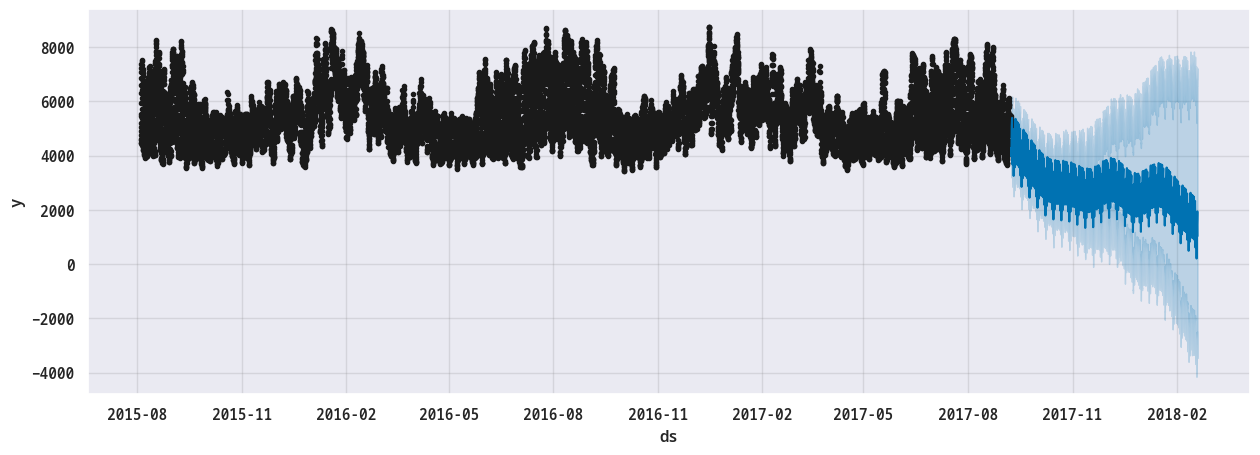

In [47]:
# Predict on training set with model
pjmw_val_fcst = best_prophet_model.predict(
        df=val_df.reset_index().rename(columns={'Datetime':'ds'})
        )

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = best_prophet_model.plot(pjmw_val_fcst, ax=ax)
plt.show()

Since we care about the next two days, let's limit the plot to that horizon.

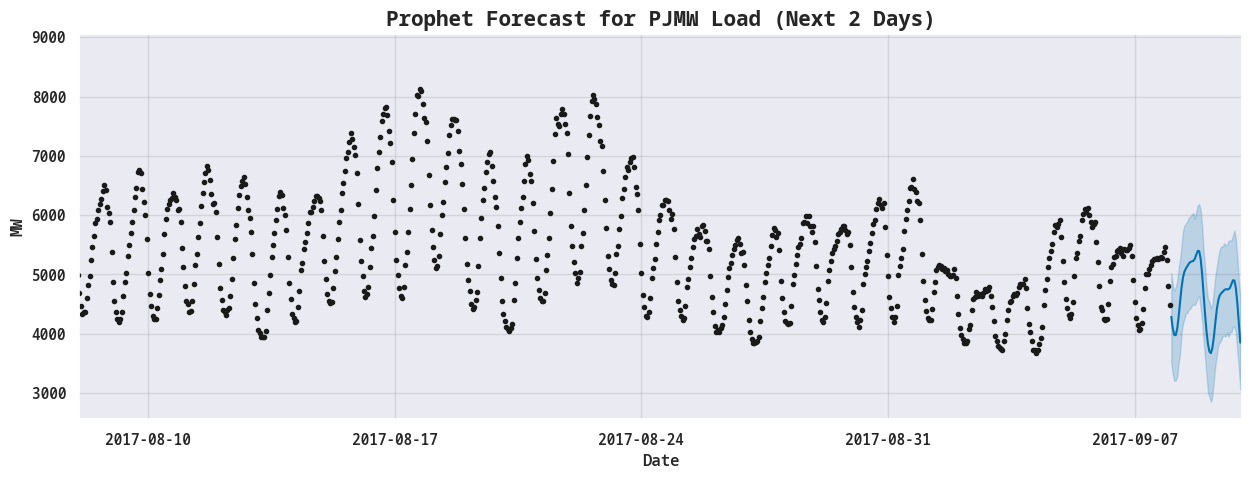

In [48]:
# Filter forecast for only 2 days
start_date = pjmw_val_fcst['ds'].min()
end_date = start_date + pd.Timedelta(days=2)
pjmw_val_fcst_2d = pjmw_val_fcst[pjmw_val_fcst['ds'] < end_date]

fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
best_prophet_model.plot(pjmw_val_fcst_2d, ax=ax)

ax.set_title('Prophet Forecast for PJMW Load (Next 2 Days)')
ax.set_xlim([
    start_date - pd.Timedelta(days=31),
    end_date
    ])

# ax.set_ylim([0, ax.get_ylim()[1]])  # Keep y-axis limits consistent

ax.set_xlabel('Date')
ax.set_ylabel('MW')

plt.show()

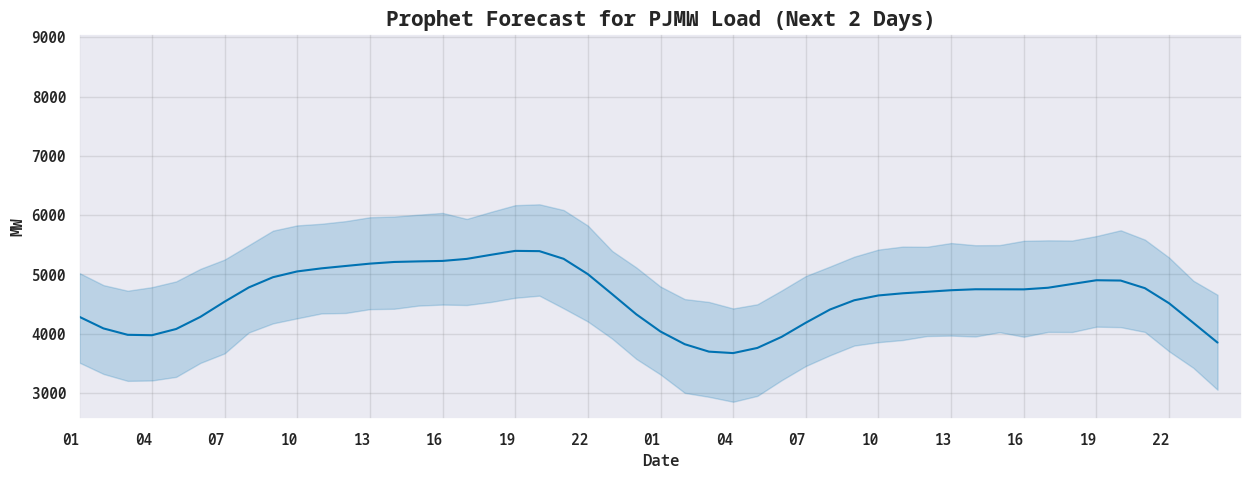

In [49]:
# Filter forecast for only 2 days
start_date = pjmw_val_fcst['ds'].min()
end_date = start_date + pd.Timedelta(days=2)
pjmw_val_fcst_2d = pjmw_val_fcst[pjmw_val_fcst['ds'] < end_date]

fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
best_prophet_model.plot(pjmw_val_fcst_2d, ax=ax)

ax.set_title('Prophet Forecast for PJMW Load (Next 2 Days)')
ax.set_xlim([
    start_date,
    end_date
    ])

# ax.set_ylim([0, ax.get_ylim()[1]])  # Keep y-axis limits consistent

ax.set_xlabel('Date')
ax.set_ylabel('MW')

x_axis_labels = pjmw_val_fcst_2d['ds'].dt.strftime('%H')

ax.set_xticks(pjmw_val_fcst_2d['ds'])
ax.set_xticklabels(x_axis_labels, ha='right')

ax.xaxis.set_major_locator(HourLocator(interval=3))

plt.show()

In [50]:
pjmw_val_fcst_2d.head(1).T

,0
ds,2017-09-08 01:00:00
trend,3999.554811
yhat_lower,3515.013004
yhat_upper,5024.852642
trend_lower,3999.554811
trend_upper,3999.554811
additive_terms,287.301808
additive_terms_lower,287.301808
additive_terms_upper,287.301808
daily,-620.410261


In [51]:
val_df.head(1).T

,18385
ds,2017-09-08 01:00:00
y,4260.0
day_of_week,Friday


## Evaluation
We will use a rolling origin evaluation, feeding all data before the cutoff
date to the model, predicting for the horizon, and then extending the training
data by the horizon. We will repeat this process to get a more accurate
measurement of the models performance, using the validation set.

In [52]:
%%time

val_data = val_df.reset_index().rename(columns={'Datetime': 'ds'})[['ds', 'y']]
train_data = train_df.copy()

step_days = 2
forecast_horizon = pd.Timedelta(days=step_days)
start_time = val_data['ds'].min()
end_time = val_data['ds'].max()

jobs = []
current_time = start_time

while current_time + forecast_horizon <= end_time:
    jobs.append(current_time)
    current_time += forecast_horizon

def forecast_one_step(current_time):
    try:
        # Subset observed validation data
        observed_val = val_data[val_data['ds'] < current_time]
        rolling_train = pd.concat([train_data, observed_val], ignore_index=True)

        # Define prediction window
        predict_window = val_data[
            (val_data['ds'] >= current_time) &
            (val_data['ds'] < current_time + forecast_horizon)
        ]

        if predict_window.empty:
            return None  # Skip

        model = Prophet()
        model.fit(rolling_train)

        future = predict_window[['ds']]
        forecast = model.predict(future)

        return {
            'forecast': pd.merge(forecast, predict_window, on='ds')
        }
    except Exception as e:
        print(f"Error at {current_time}: {e}")
        return None

with Pool(processes=cpu_count()) as pool:
    results = pool.map(forecast_one_step, jobs)

20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:21:29 - cmdstanpy - INFO - Chain [1] start processing
20:23:36 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:43 - cmdstanpy - INFO - Chain [1] start processing
20:23:43 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chai

20:39:19 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:25 - cmdstanpy - INFO - Chain [1] start processing
20:39:49 - cmdstanpy - INFO - Chain [1] done processing
20:39:50 - cmdstanpy - INFO - Chain [1] done processing
20:39:54 - cmdstanpy - INFO - Chain [1] start processing
20:40:17 - cmdstanpy - INFO - Chain [1] done processing
20:40:18 - cmdstanpy - INFO - Chain [1] done processing
20:40:21 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] done processing
20:40:26 - cmdstanpy - INFO - Chain [1] done processing
20:40:52 - cmdstanpy - INFO - Chain [1] done processing
20:40:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:10 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.24 s, sys: 532 ms, total: 1.77 s
Wall time: 19min 45s


<IPython.core.display.Javascript object>

In [53]:
all_forecasts = [res['forecast'] for res in results if res is not None]
forecast_df = pd.concat(all_forecasts, ignore_index=True)

In [54]:
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2017-09-08 01:00:00,4158.918018,3562.192799,5120.104445,4158.918018,4158.918018,143.067086,143.067086,143.067086,-620.428849,...,148.146044,148.146044,615.349891,615.349891,615.349891,0.0,0.0,0.0,4301.985105,4260.0
1,2017-09-08 02:00:00,4158.382057,3289.837911,4910.154432,4158.382057,4158.382057,-52.839108,-52.839108,-52.839108,-813.494081,...,147.185781,147.185781,613.469192,613.469192,613.469192,0.0,0.0,0.0,4105.542950,4105.0
2,2017-09-08 03:00:00,4157.846097,3173.406119,4754.929044,4157.846097,4157.846097,-160.154421,-160.154421,-160.154421,-917.697204,...,145.955308,145.955308,611.587475,611.587475,611.587475,0.0,0.0,0.0,3997.691675,4063.0
3,2017-09-08 04:00:00,4157.310136,3242.996077,4806.251868,4157.310136,4157.310136,-166.428248,-166.428248,-166.428248,-920.538567,...,144.405569,144.405569,609.704751,609.704751,609.704751,0.0,0.0,0.0,3990.881888,3989.0
4,2017-09-08 05:00:00,4156.774175,3326.009689,4866.200595,4156.774175,4156.774175,-61.066495,-61.066495,-61.066495,-811.372861,...,142.485333,142.485333,607.821033,607.821033,607.821033,0.0,0.0,0.0,4095.707680,4086.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,2018-02-16 20:00:00,5302.789266,6063.870317,7684.486254,5302.789266,5302.789266,1553.938402,1553.938402,1553.938402,635.069032,...,31.358405,31.358405,887.510965,887.510965,887.510965,0.0,0.0,0.0,6856.727669,6158.0
3884,2018-02-16 21:00:00,5302.720153,5916.473136,7538.389423,5302.720153,5302.720153,1423.810361,1423.810361,1423.810361,519.785219,...,17.842601,17.842601,886.182541,886.182541,886.182541,0.0,0.0,0.0,6726.530514,6135.0
3885,2018-02-16 22:00:00,5302.651039,5626.222825,7257.820660,5302.651039,5302.651039,1165.089822,1165.089822,1165.089822,276.824597,...,3.416994,3.416994,884.848231,884.848231,884.848231,0.0,0.0,0.0,6467.740861,6049.0
3886,2018-02-16 23:00:00,5302.581926,5323.656571,6976.067775,5302.581926,5302.581926,835.039925,835.039925,835.039925,-36.576380,...,-11.891731,-11.891731,883.508036,883.508036,883.508036,0.0,0.0,0.0,6137.621851,5818.0


In [55]:
forecast_df['mae'] = np.abs(forecast_df['yhat'] - forecast_df['y'])
forecast_df['mape'] = np.abs(forecast_df['yhat'] - forecast_df['y']) / forecast_df['y']

forecast_df[['y', 'yhat', 'mae', 'mape']].describe()

,y,yhat,mae,mape
count,3888.000000,3888.000000,3888.000000,3888.000000
mean,5855.307870,5806.868066,588.729473,0.098252
std,1084.555988,1047.238162,503.500522,0.080526
min,3665.000000,3060.004085,0.406223,0.000060
25%,5106.000000,5079.006181,207.573385,0.037428
50%,5730.000000,5733.971003,453.334250,0.081086
75%,6548.250000,6585.100990,826.767272,0.134398
max,9342.000000,8715.517140,2833.734162,0.535478


We are about 10% off on average in our predictions. Let's use the interval provided by prophet.

Let's see how far off we are using the confidence intervals provided by prophet.

In [56]:
forecast_df['yhat_lower_adj'] = forecast_df[['yhat_lower', 'y']].max(axis=1)
forecast_df['yhat_upper_adj'] = forecast_df[['yhat_upper', 'y']].min(axis=1)
forecast_df['yhat_lower_adj_mae'] = np.abs(forecast_df['yhat_lower_adj'] - forecast_df['y'])
forecast_df['yhat_upper_adj_mae'] = np.abs(forecast_df['yhat_upper_adj'] - forecast_df['y'])
forecast_df['yhat_adj_mae'] = forecast_df['yhat_lower_adj_mae'] + forecast_df['yhat_upper_adj_mae']
forecast_df['yhat_adj_mape'] = forecast_df['yhat_adj_mae'] / forecast_df['y']
forecast_df['ci_range'] = forecast_df['yhat_upper'] - forecast_df['yhat_lower']
forecast_df['ci_range_pct'] = forecast_df['ci_range'] / forecast_df['y'] * 100

forecast_df[['mae', 'yhat_adj_mae', 'mape', 'yhat_adj_mape', 'ci_range_pct', 'yhat_lower_adj_mae', 'yhat_upper_adj_mae']].describe()

,mae,yhat_adj_mae,mape,yhat_adj_mape,ci_range_pct,yhat_lower_adj_mae,yhat_upper_adj_mae
count,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000
mean,588.729473,134.354583,0.098252,0.021009,27.448194,60.528591,73.825992
std,503.500522,306.577329,0.080526,0.049431,5.070057,233.960827,219.525525
min,0.406223,0.000000,0.000060,0.000000,16.290754,0.000000,0.000000
25%,207.573385,0.000000,0.037428,0.000000,23.789545,0.000000,0.000000
50%,453.334250,0.000000,0.081086,0.000000,27.136231,0.000000,0.000000
75%,826.767272,46.904902,0.134398,0.007666,30.459629,0.000000,0.000000
max,2833.734162,2050.012892,0.535478,0.374979,44.377480,2050.012892,1435.921477


How often does our confidence interval contain y?

In [169]:
pct = ((forecast_df['yhat_lower'] <= forecast_df['y']) & (forecast_df['yhat_upper'] >= forecast_df['y'])).mean()
print(f"Percentage of actuals within confidence interval: {pct:.1%}")

Percentage of actuals within confidence interval: 73.0%


Around 73% of the time our confidence interval contains the actual value.

Let's see the distribution of the absolute errors, for yhat and adjusted yhat.

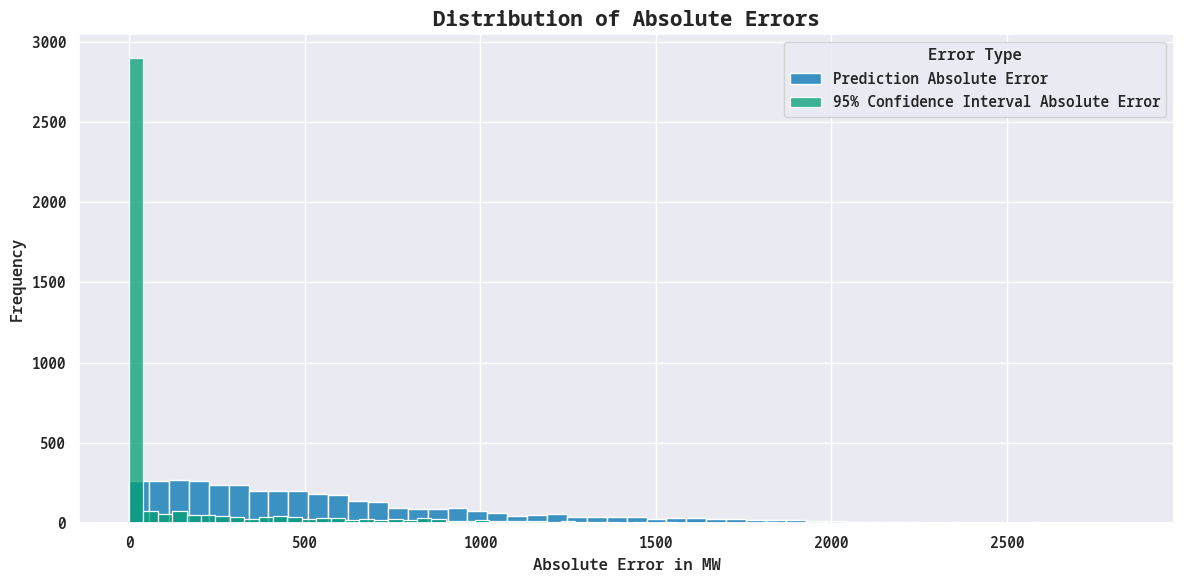

In [106]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=forecast_df,
    x='mae',
    bins=50,
    ax=ax,
    color=blue,
    label='Prediction Absolute Error'
)

sns.histplot(
    data=forecast_df,
    x='yhat_adj_mae',
    bins=50,
    ax=ax,
    color=green,
    label=f'{ci_str} Confidence Interval Absolute Error'
)

ax.set_title('Distribution of Absolute Errors')
ax.set_xlabel('Absolute Error in MW')
ax.set_ylabel('Frequency')
ax.legend(title='Error Type')
plt.tight_layout()
plt.show()

Let's see the distribution of the absolute errors, excluding the zero errors.

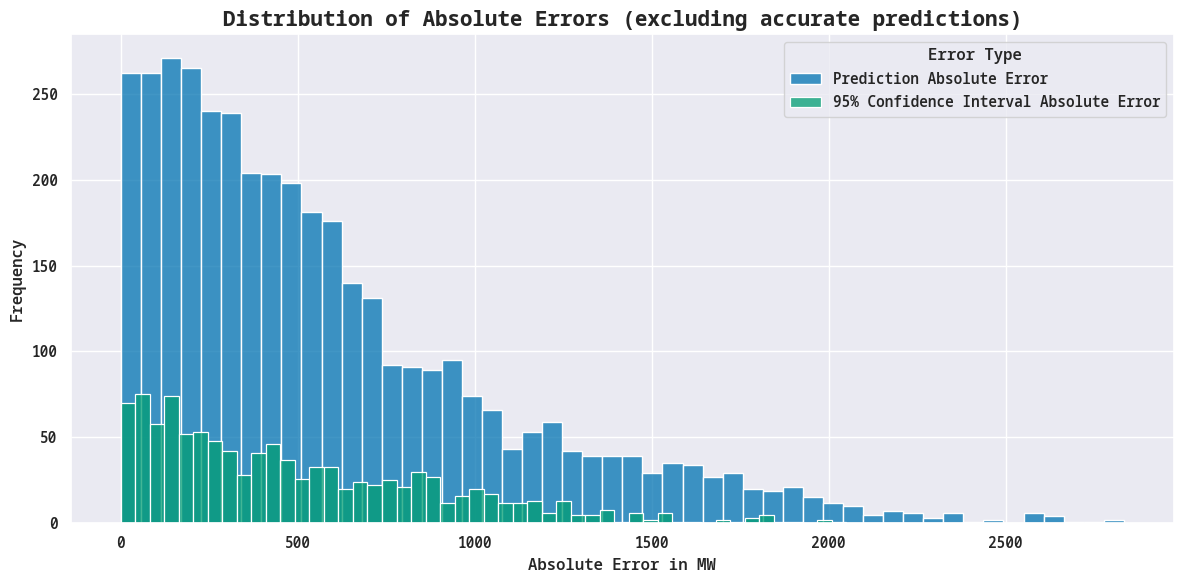

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))

viz_df_mae = forecast_df[forecast_df['mae'] != 0]
viz_df_mae_adj = forecast_df[forecast_df['yhat_adj_mae'] != 0]

sns.histplot(
    data=viz_df_mae,
    x='mae',
    bins=50,
    ax=ax,
    color=blue,
    label='Prediction Absolute Error'
)

sns.histplot(
    data=viz_df_mae_adj,
    x='yhat_adj_mae',
    bins=50,
    ax=ax,
    color=green,
    label=f'{ci_str} Confidence Interval Absolute Error'
)

ax.set_title('Distribution of Absolute Errors (excluding accurate predictions)')
ax.set_xlabel('Absolute Error in MW')
ax.set_ylabel('Frequency')
ax.legend(title='Error Type')
plt.tight_layout()
plt.show()

When using the confidence interval instead of the predicted value from prophet, our error is reduced considerably. If the range provided as the confidence interval is acceptable, we can use it to have a more accurate estimate of the actual consumption.

In [75]:
forecast_df['mean_error'] = forecast_df['yhat'] - forecast_df['y']

forecast_df['mean_error_adj'] = np.where(
    forecast_df['yhat_lower'] >= forecast_df['y'],
    forecast_df['yhat_lower_adj'] - forecast_df['y'],
    forecast_df['yhat_upper_adj'] - forecast_df['y']
)

In [76]:
cols = ['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'mean_error', 'mean_error_adj']

In [77]:
forecast_df[forecast_df['mean_error_adj'] == 0][cols].head(3).T

,0,1,2
ds,2017-09-08 01:00:00,2017-09-08 02:00:00,2017-09-08 03:00:00
y,4260.0,4105.0,4063.0
yhat,4301.985105,4105.54295,3997.691675
yhat_lower,3562.192799,3289.837911,3173.406119
yhat_upper,5120.104445,4910.154432,4754.929044
mean_error,41.985105,0.54295,-65.308325
mean_error_adj,0.0,0.0,0.0


In [78]:
forecast_df[forecast_df['mean_error_adj'] > 0][cols].head(3).T

,615,1790,1791
ds,2017-10-03 16:00:00,2017-11-21 15:00:00,2017-11-21 16:00:00
y,4608.0,5431.0,5423.0
yhat,5400.133973,6387.911515,6406.356973
yhat_lower,4608.015158,5611.262012,5610.062974
yhat_upper,6224.321673,7212.164193,7188.875816
mean_error,792.133973,956.911515,983.356973
mean_error_adj,0.015158,180.262012,187.062974


In [79]:
forecast_df[forecast_df['mean_error_adj'] < 0][cols].head(3).T

,133,134,135
ds,2017-09-13 14:00:00,2017-09-13 15:00:00,2017-09-13 16:00:00
y,5802.0,5904.0,5972.0
yhat,5007.119242,5026.725599,5045.00239
yhat_lower,4188.342944,4261.901307,4262.492855
yhat_upper,5778.857097,5822.513139,5859.191779
mean_error,-794.880758,-877.274401,-926.99761
mean_error_adj,-23.142903,-81.486861,-112.808221


In [84]:
forecast_df[forecast_df['mean_error'] == 0][cols].head(3).T

""
ds
y
yhat
yhat_lower
yhat_upper
mean_error
mean_error_adj


In [85]:
forecast_df[forecast_df['mean_error'] > 0][cols].head(3).T

,0,1,3
ds,2017-09-08 01:00:00,2017-09-08 02:00:00,2017-09-08 04:00:00
y,4260.0,4105.0,3989.0
yhat,4301.985105,4105.54295,3990.881888
yhat_lower,3562.192799,3289.837911,3242.996077
yhat_upper,5120.104445,4910.154432,4806.251868
mean_error,41.985105,0.54295,1.881888
mean_error_adj,0.0,0.0,0.0


In [86]:
forecast_df[forecast_df['mean_error'] < 0][cols].head(3).T

,2,5,6
ds,2017-09-08 03:00:00,2017-09-08 06:00:00,2017-09-08 07:00:00
y,4063.0,4315.0,4770.0
yhat,3997.691675,4300.066203,4556.2323
yhat_lower,3173.406119,3500.151159,3819.901664
yhat_upper,4754.929044,5075.380535,5375.933167
mean_error,-65.308325,-14.933797,-213.7677
mean_error_adj,0.0,0.0,0.0


In [87]:
forecast_df.sort_values('mean_error').head(5).T

,2815,2814,471,472,2907
ds,2018-01-03 08:00:00,2018-01-03 07:00:00,2017-09-27 16:00:00,2017-09-27 17:00:00,2018-01-07 04:00:00
trend,5997.029334,5996.928863,5366.81907,5366.867486,6461.429828
yhat_lower,6170.082779,5874.767909,4576.189794,4625.378794,5287.168849
yhat_upper,7731.79654,7512.524033,6089.078523,6216.894649,6885.73015
trend_lower,5997.029334,5996.928863,5366.81907,5366.867486,6461.429828
trend_upper,5997.029334,5996.928863,5366.81907,5366.867486,6461.429828
additive_terms,927.852254,680.952442,2.247413,48.660384,-333.893017
additive_terms_lower,927.852254,680.952442,2.247413,48.660384,-333.893017
additive_terms_upper,927.852254,680.952442,2.247413,48.660384,-333.893017
daily,-70.109463,-313.428374,433.654721,480.05958,-901.655693


In [88]:
forecast_df[forecast_df['yhat_upper'] < forecast_df['y']].T

,133,134,135,136,137,140,180,181,182,183,...,3680,3698,3699,3700,3701,3702,3703,3704,3798,3799
ds,2017-09-13 14:00:00,2017-09-13 15:00:00,2017-09-13 16:00:00,2017-09-13 17:00:00,2017-09-13 18:00:00,2017-09-13 21:00:00,2017-09-15 13:00:00,2017-09-15 14:00:00,2017-09-15 15:00:00,2017-09-15 16:00:00,...,2018-02-08 09:00:00,2018-02-09 03:00:00,2018-02-09 04:00:00,2018-02-09 05:00:00,2018-02-09 06:00:00,2018-02-09 07:00:00,2018-02-09 08:00:00,2018-02-09 09:00:00,2018-02-13 07:00:00,2018-02-13 08:00:00
trend,4217.479058,4217.067271,4216.655484,4216.243698,4215.831911,4214.59655,4289.124588,4288.758913,4288.393238,4288.027563,...,5528.239954,5673.969001,5674.024658,5674.080315,5674.135972,5674.191628,5674.247285,5674.302942,5408.129084,5408.102789
yhat_lower,4188.342944,4261.901307,4262.492855,4277.003814,4387.602111,4377.785936,4140.976018,4136.676981,4117.369708,4154.075034,...,5886.595866,5017.363489,4981.026157,5129.539806,5252.475992,5564.173428,5848.916502,5944.918747,5417.019266,5701.720131
yhat_upper,5778.857097,5822.513139,5859.191779,5838.082404,5947.056725,5951.392394,5655.558442,5691.377754,5711.049846,5654.380696,...,7470.759124,6583.94699,6543.209571,6701.462413,6917.744208,7132.046557,7447.743096,7458.169871,6985.931118,7301.605955
trend_lower,4217.479058,4217.067271,4216.655484,4216.243698,4215.831911,4214.59655,4289.124588,4288.758913,4288.393238,4288.027563,...,5528.239954,5673.969001,5674.024658,5674.080315,5674.135972,5674.191628,5674.247285,5674.302942,5408.129084,5408.102789
trend_upper,4217.479058,4217.067271,4216.655484,4216.243698,4215.831911,4214.59655,4289.124588,4288.758913,4288.393238,4288.027563,...,5528.239954,5673.969001,5674.024658,5674.080315,5674.135972,5674.191628,5674.247285,5674.302942,5408.129084,5408.102789
additive_terms,789.640184,809.658328,828.346905,874.449061,955.697554,931.867335,604.851458,633.753431,644.214463,652.329609,...,1186.237307,102.16939,101.242718,214.597951,429.320244,692.660095,931.769645,1094.437254,812.100256,1051.219352
additive_terms_lower,789.640184,809.658328,828.346905,874.449061,955.697554,931.867335,604.851458,633.753431,644.214463,652.329609,...,1186.237307,102.16939,101.242718,214.597951,429.320244,692.660095,931.769645,1094.437254,812.100256,1051.219352
additive_terms_upper,789.640184,809.658328,828.346905,874.449061,955.697554,931.867335,604.851458,633.753431,644.214463,652.329609,...,1186.237307,102.16939,101.242718,214.597951,429.320244,692.660095,931.769645,1094.437254,812.100256,1051.219352
daily,383.050283,403.709021,423.081279,469.931996,552.012801,531.322841,344.935226,383.351733,404.179284,423.542355,...,116.39105,-890.212428,-889.556912,-774.335124,-557.402761,-291.448747,-49.259721,117.013706,-289.635396,-47.503591


Let's see the distribution of the non-absolute errors, for yhat and adjusted yhat.

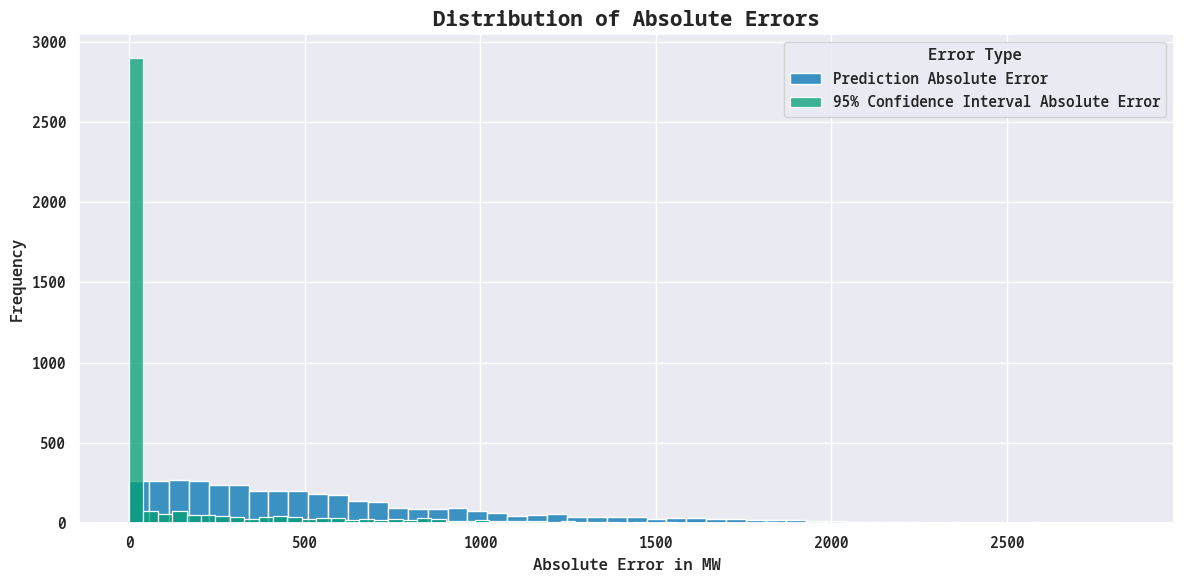

In [100]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=forecast_df,
    x='mae',
    bins=50,
    ax=ax,
    color=blue,
    label='Prediction Absolute Error'
)

sns.histplot(
    data=forecast_df,
    x='yhat_adj_mae',
    bins=50,
    ax=ax,
    color=green,
    label=f'{ci_str} Confidence Interval Absolute Error'
)

ax.set_title('Distribution of Absolute Errors (excluding accurate predictions)')
ax.set_xlabel('Absolute Error in MW')
ax.set_ylabel('Frequency')
ax.legend(title='Error Type')
plt.tight_layout()
plt.show()

Let's see same distribution excluding the zero errors.

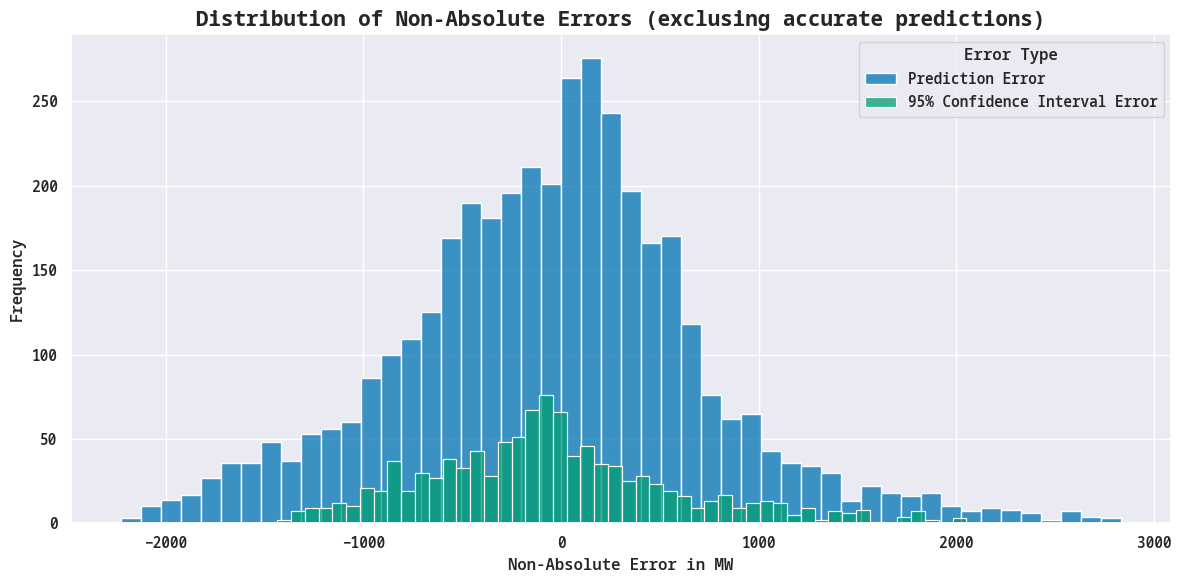

In [107]:
fig, ax = plt.subplots(figsize=(12, 6))

viz_df_mean_error = forecast_df[forecast_df['mean_error'] != 0]
viz_df_mean_error_adj = forecast_df[forecast_df['mean_error_adj'] != 0]

sns.histplot(
    data=viz_df_mean_error,
    x='mean_error',
    bins=50,
    ax=ax,
    color=blue,
    label='Prediction Error'
)

sns.histplot(
    data=viz_df_mean_error_adj,
    x='mean_error_adj',
    bins=50,
    ax=ax,
    color=green,
    label=f'{ci_str} Confidence Interval Error'
)

ax.set_title('Distribution of Non-Absolute Errors (exclusing accurate predictions)')
ax.set_xlabel('Non-Absolute Error in MW')
ax.set_ylabel('Frequency')
ax.legend(title='Error Type')
plt.tight_layout()
plt.show()

Are we predicting consumption on all hours of the day with the same accuracy?

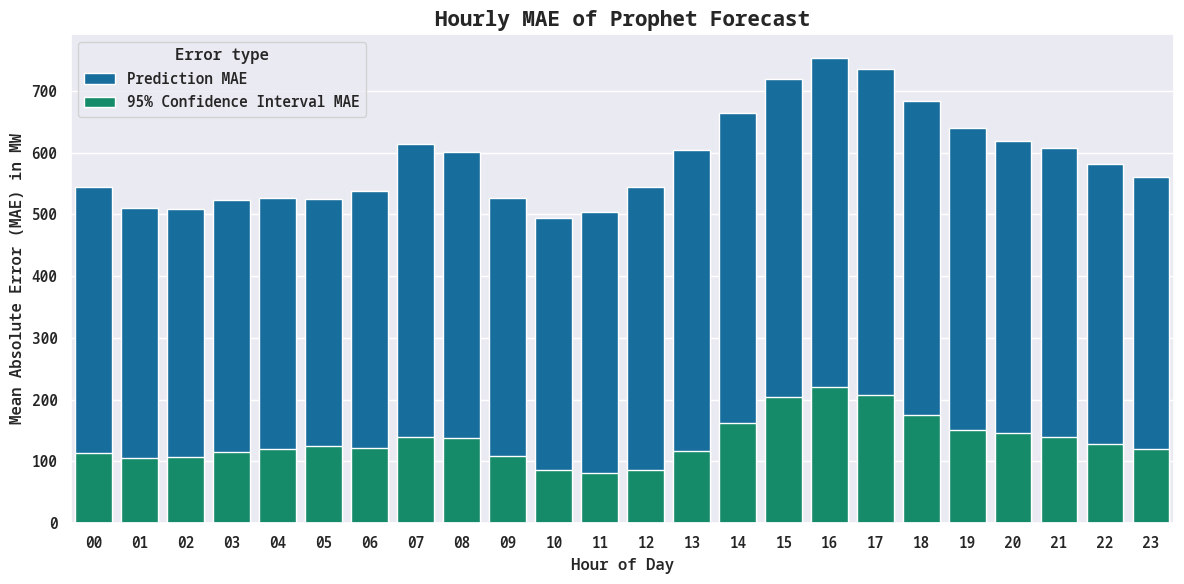

In [91]:
# plot the hourly MAE, with hue for adjusted yhat and yhat
fig, ax = plt.subplots(figsize=(12, 6))

viz_df = forecast_df.copy()[['ds', 'mae', 'yhat_adj_mae']]
viz_df = pd.melt(
    viz_df,
    id_vars=['ds'],
    value_vars=['mae', 'yhat_adj_mae'],
    var_name='error_type',
    value_name='error'
)

viz_df['hour'] = viz_df['ds'].dt.hour

viz_df['error_type'] = viz_df['error_type'].map({
    'mae': 'Prediction MAE',
    'yhat_adj_mae': f'{ci_str} Confidence Interval MAE'
    })

sns.barplot(
    data=viz_df,
    x='hour',
    y='error',
    hue='error_type',
    ax=ax,
    palette=[blue, green],
    errorbar=None,
    dodge=False
    )

ax.set_title('Hourly MAE of Prophet Forecast')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Absolute Error (MAE) in MW')
xticks = np.arange(0, 24, 1)
ax.set_xticks(xticks)
ax.set_xticklabels(
        [f'{x:02d}' for x in xticks]
        )

# set legend title
ax.legend(title='Error type', loc='upper left')


plt.tight_layout()
plt.show()

We are a little more accurate during the night hours but not by much.

Let's plot the hourly consumption to see if there are any patterns.

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_78876/3011473349.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  viz_df = viz_df.groupby(['hour', 'day_of_week'], as_index=False).mean() \



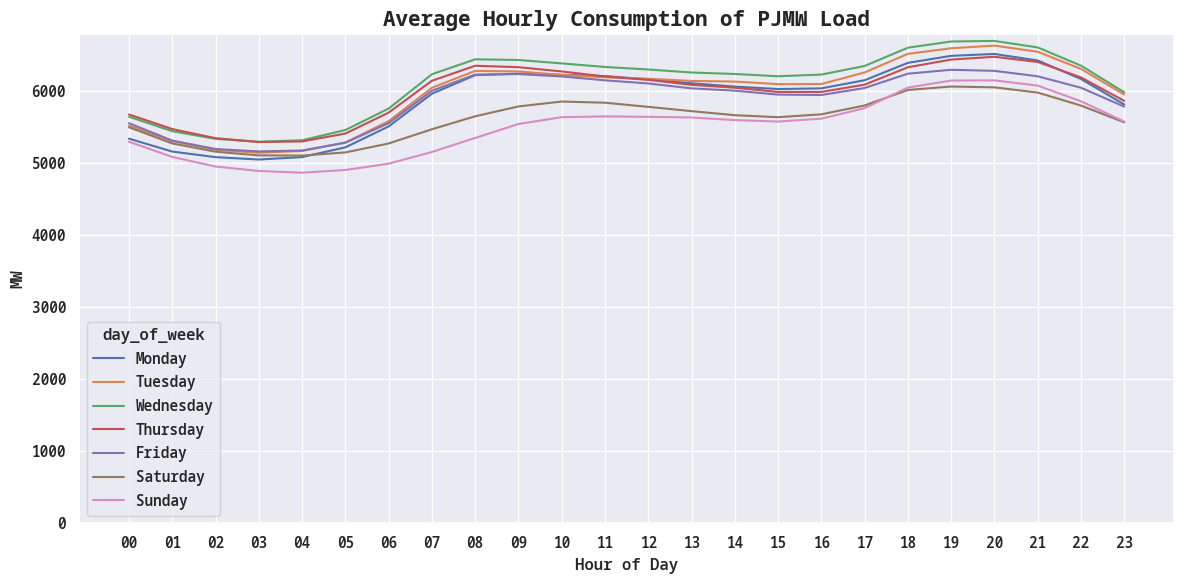

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))

viz_df = val_df.copy()
viz_df['hour'] = viz_df['ds'].dt.hour
viz_df['day_of_week'] = viz_df['ds'].dt.day_name()
viz_df['day_of_week'] = pd.Categorical(
    viz_df['day_of_week'],
    categories=[
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ],
    ordered=True
)
viz_df = viz_df.groupby(['hour', 'day_of_week'], as_index=False).mean() \
        .rename(columns={'y': 'mw'})


sns.lineplot(
    data=viz_df,
    x='hour',
    y='mw',
    ax=ax,
    linewidth=1.5,
    hue='day_of_week'
)
ax.set_title('Average Hourly Consumption of PJMW Load')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('MW')
xticks = np.arange(0, 24, 1)
ax.set_xticks(xticks)
ax.set_xticklabels(
        [f'{x:02d}' for x in xticks]
        )

ax.set_ylim([0, ax.get_ylim()[1]])  # Keep y-axis limits consistent
plt.tight_layout()
plt.show()


As expected, consumption is on average a little lower during the night hours and we can focus on recharging batteries during those hours with enough confidence that our predictions are accurate and that estimated costs are minimized. We can also keep in mind that during midday, even though on average consumption is not at its highest, we have less accurate predictions and could make our users use the grid resulting in higher costs. If we could prioritize times of day when average consumption is low **and** our predictions are as accurate as possible, we will consistently minimize costs for our users.

## Conclusion
We used Facebook's Prophet to predict energy consumption for the next two
days. Our model returned a prediction about energy consumption for each hour
of the next 2 days, as well as a confidence interval (95%) for the actual
consumption. Using the prediction of the model as input, an algorithm can
optimize the use of batteries to minimize energy costs within the next two
days.
The model is about 10% off in its predictions (MAPE ~= 0.1). Using the
confidence intervals we can reduce the error to about 2% on average. The
confidence interval contains the actual energy consumption about 73% of the
time for the validation set.